#Imports, Settings and Reading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
import time

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/nidhicodes4045/datascience442/refs/heads/main/merged_data.csv")
#Dataset for visualization from https://www.kaggle.com/datasets/alejopaullier/usa-counties-coordinates/data
cfips_df = pd.read_csv('/content/cfips_location.csv')
df = df.drop(['Unnamed: 0'], axis = 1).copy() # Dropping useless column

In [3]:
df.head()

,County,Population,State,mergedkeycol,Housing Data.Residing in Group Quarters,Housing Data.Total Housing Units,Vehicle Access.1 Mile,Vehicle Access.1/2 Mile,Vehicle Access.10 Miles,Vehicle Access.20 Miles,...,Population.Population per Square Mile,Sales.Accommodation and Food Services Sales,Sales.Retail Sales,Employment.Firms.Total,Employment.Firms.Women-Owned,Employment.Firms.Men-Owned,Employment.Firms.Minority-Owned,Employment.Firms.Nonminority-Owned,Employment.Firms.Veteran-Owned,Employment.Firms.Nonveteran-Owned
0,autaugacounty,54571,al,autaugacountyal,455,20221,834,1045,222.0,0,...,91.8,93431.0,607854.0,2949,1093,1499,616.0,2160,285,2401
1,baldwincounty,182265,al,baldwincountyal,2307,73180,1653,2178,32.0,0,...,114.6,560602.0,3145789.0,19732,6505,10935,2130.0,16893,2364,16183
2,barbourcounty,27457,al,barbourcountyal,3193,9820,545,742,201.0,0,...,31.0,26157.0,206477.0,1687,760,755,657.0,941,147,1445
3,bibbcounty,22915,al,bibbcountyal,2224,7953,312,441,0.0,0,...,36.8,10136.0,118871.0,1310,254,958,205.0,1050,288,967
4,blountcounty,57322,al,blountcountyal,489,21578,752,822,0.0,0,...,88.9,27146.0,298745.0,4550,1400,2746,368.0,4011,353,4030


#SQLite in-memory Querry Runtime

In [4]:
# Load into SQLite in-memory database
conn = sqlite3.connect(":memory:")
df.to_sql("merged_data", conn, index=False, if_exists="replace")

# SQL Query (based on our question: food insecurity & vehicle access)
query = """
SELECT
    County,
    State,
    "Low Access Numbers.Low Income People.1/2 Mile" AS low_access_low_income,
    "Vehicle Access.1/2 Mile" AS vehicle_access_half_mile,
    Population AS total_population
FROM merged_data
WHERE "Low Access Numbers.Low Income People.1/2 Mile" IS NOT NULL
  AND "Vehicle Access.1/2 Mile" IS NOT NULL
  AND County IS NOT NULL
  ORDER BY total_population DESC
"""

# Time and run query
start = time.time()
query_result = pd.read_sql_query(query, conn)
end = time.time()

print(f"Returned {query_result.shape[0]} rows in {end - start:.3f} seconds.")
query_result.head(2)


Returned 3138 rows in 0.073 seconds.


,County,State,low_access_low_income,vehicle_access_half_mile,total_population
0,losangelescounty,ca,1139072,70754,9818605
1,cookcounty,il,602198,83246,5194675


## Estimated No Vehicle Access

In [5]:
# Load from query
plot_df = pd.read_sql_query(query, conn)

# Calculate proxy for no access: low_access - people with vehicle access
plot_df['estimated_no_vehicle_low_access'] = plot_df['low_access_low_income'] - plot_df['vehicle_access_half_mile']
plot_df['estimated_no_vehicle_low_access'] = plot_df['estimated_no_vehicle_low_access'].clip(lower=0)

plot_df = plot_df.rename(columns={
    'estimated_no_vehicle_low_access': 'no_vehicle_proxy'
})

#Add county_clean column to plot_df to match cfips_df for merging
plot_df['county_clean'] = plot_df['County'].str.lower().str.replace(' ', '').str.strip()

In [6]:
plot_df.head()

,County,State,low_access_low_income,vehicle_access_half_mile,total_population,no_vehicle_proxy,county_clean
0,losangelescounty,ca,1139072,70754,9818605,1068318,losangelescounty
1,cookcounty,il,602198,83246,5194675,518952,cookcounty
2,harriscounty,tx,824879,42521,4092459,782358,harriscounty
3,maricopacounty,az,757010,47353,3817117,709657,maricopacounty
4,sandiegocounty,ca,389863,20262,3095313,369601,sandiegocounty


##Trying out some fun visual

In [7]:
cfips_df.head()

,cfips,name,lng,lat
0,1059,Franklin,-87.843283,34.442381
1,13111,Fannin,-84.319296,34.864126
2,19109,Kossuth,-94.206898,43.204140
3,40115,Ottawa,-94.810589,36.835878
4,42115,Susquehanna,-75.800905,41.821277


In [8]:
# Load the FIPS location mapping
cfips_df = pd.read_csv('/content/cfips_location.csv')

# Preview and clean
cfips_df.columns = cfips_df.columns.str.strip().str.lower()
cfips_df = cfips_df.rename(columns={'cfips': 'fips'})

# Make a matching "county_clean" column
cfips_df['county_clean'] = cfips_df['name'].str.lower().str.replace(' ', '').str.strip() + 'county'

cfips_df[['name', 'county_clean', 'fips']].head()

,name,county_clean,fips
0,Franklin,franklincounty,1059
1,Fannin,fannincounty,13111
2,Kossuth,kossuthcounty,19109
3,Ottawa,ottawacounty,40115
4,Susquehanna,susquehannacounty,42115


In [9]:
# Merge with FIPS codes
plot_df = pd.merge(
    plot_df,
    cfips_df[['county_clean', 'fips']],
    on='county_clean',
    how='left'
)

In [10]:
plot_df.dtypes

,0
County,object
State,object
low_access_low_income,int64
vehicle_access_half_mile,int64
total_population,int64
no_vehicle_proxy,int64
county_clean,object
fips,float64


In [11]:
plot_df.head(20)

,County,State,low_access_low_income,vehicle_access_half_mile,total_population,no_vehicle_proxy,county_clean,fips
0,losangelescounty,ca,1139072,70754,9818605,1068318,losangelescounty,6037.0
1,cookcounty,il,602198,83246,5194675,518952,cookcounty,27031.0
2,cookcounty,il,602198,83246,5194675,518952,cookcounty,13075.0
3,cookcounty,il,602198,83246,5194675,518952,cookcounty,17031.0
4,harriscounty,tx,824879,42521,4092459,782358,harriscounty,48201.0
5,harriscounty,tx,824879,42521,4092459,782358,harriscounty,13145.0
6,maricopacounty,az,757010,47353,3817117,709657,maricopacounty,4013.0
7,sandiegocounty,ca,389863,20262,3095313,369601,sandiegocounty,6073.0
8,orangecounty,ca,285793,16649,3010232,269144,orangecounty,18117.0
9,orangecounty,ca,285793,16649,3010232,269144,orangecounty,51137.0


In [12]:
import plotly.express as px

# Ensure FIPS is 5-digit string format
plot_df['fips'] = plot_df['fips'].astype(str).str.zfill(5)

fig = px.choropleth(
    plot_df,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='fips',
    color='low_access_low_income',
    color_continuous_scale="Reds",
    scope="usa",
    labels={'low_access_low_income': 'Low-Income w/o Access'},
    title="Food Insecurity (Low-Income w/o Supermarket Access) by US County"
)
fig.show()


In [13]:
# Check your data sanity
print("Number of rows:", len(plot_df))
print("Non-null FIPS codes:", plot_df['fips'].notna().sum())
print("Unique FIPS codes:", plot_df['fips'].nunique())
print("Column preview:", plot_df.columns.tolist())
plot_df[['fips', 'low_access_low_income']].dropna().head()


Number of rows: 14814
Non-null FIPS codes: 14814
Unique FIPS codes: 3053
Column preview: ['County', 'State', 'low_access_low_income', 'vehicle_access_half_mile', 'total_population', 'no_vehicle_proxy', 'county_clean', 'fips']


,fips,low_access_low_income
0,6037.0,1139072
1,27031.0,602198
2,13075.0,602198
3,17031.0,602198
4,48201.0,824879


The choropleth visualization reveals stark geographic disparities in food access among low-income populations. After log-scaling the raw counts of low-income individuals without supermarket access within 0.5 miles, distinct clusters of high food insecurity emerge. Notably, many counties across the Southeastern US and parts of Texas show significantly higher levels of food insecurity. The log transformation helped highlight meaningful differences across counties, especially where raw values were skewed by a few extreme outliers. This visualization supports the hypothesis that geographic access remains a crucial factor in food insecurity, particularly when compounded by socioeconomic status.

#Question of Interest

How does access to transportation (vehicle availability) relate to food insecurity in low-income areas across US counties?

Unit of analysis = US County

Main columns of interest:

1.   "Low Access Numbers.Low Income People.1/2 Mile" → food-insecure low-income population
2.   "Transportation.Households with No Vehicle Available" → households without vehicles
3.   "Population" or "Urban Influence Code" (for context/density control)

# Exploratory Data Analysis

*   Univariate Analysis
*   Bivariate Analysis
*   Multivariate Analysis




## Univariate Analysis

---

*   Explore the distribution of each variable





In [14]:
plot_df.columns

Index(['County', 'State', 'low_access_low_income', 'vehicle_access_half_mile',
       'total_population', 'no_vehicle_proxy', 'county_clean', 'fips'],
      dtype='object')

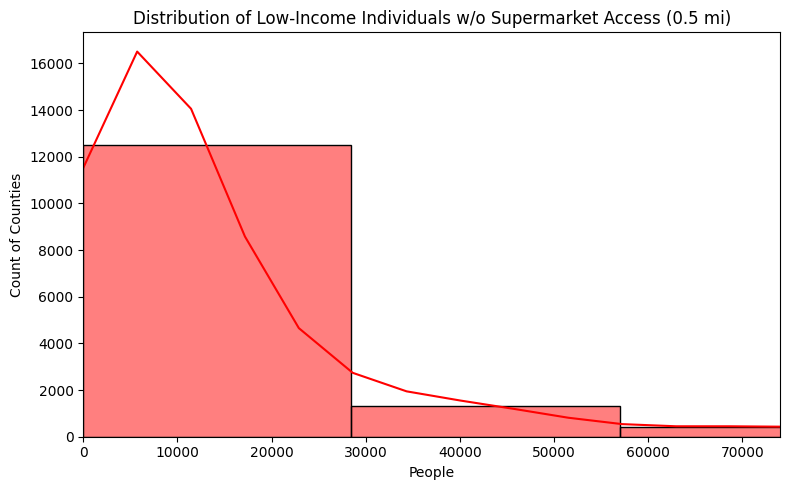

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate 95th percentile to trim x-axis
x_max = plot_df['low_access_low_income'].quantile(0.95)

plt.figure(figsize=(8, 5))
sns.histplot(plot_df['low_access_low_income'], bins=40, kde=True, color='red')
plt.xlim(0, x_max)  # Zoom into bulk of the data
plt.title("Distribution of Low-Income Individuals w/o Supermarket Access (0.5 mi)")
plt.xlabel("People")
plt.ylabel("Count of Counties")
plt.tight_layout()
plt.show()


In [16]:
from scipy.stats import skew, kurtosis
skewness = skew(plot_df['low_access_low_income'])
kurt = kurtosis(plot_df['low_access_low_income'])
print(f"Skewness: {skewness:.2f}, Kurtosis: {kurt:.2f}")


Skewness: 7.83, Kurtosis: 104.32


###Inference:

The distribution of low-income individuals without nearby supermarket access exhibits extreme right skew (Skewness = 7.83) and high kurtosis (104.32), indicating that food insecurity is highly concentrated in a small number of counties while most counties experience low to moderate impact.

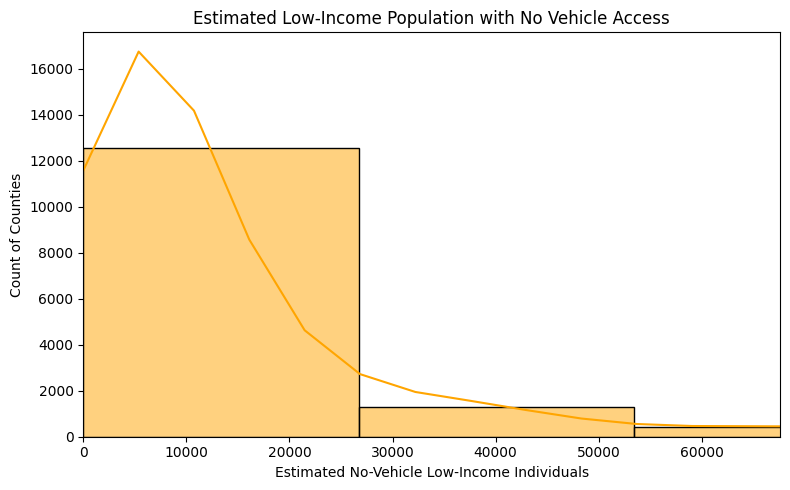

In [17]:
# Calculate 95th percentile to trim x-axis
x_max = plot_df['no_vehicle_proxy'].quantile(0.95)

plt.figure(figsize=(8, 5))
sns.histplot(plot_df['no_vehicle_proxy'], bins=40, kde=True, color='orange')
plt.xlim(0, x_max)  # Zoom into the bulk of counties
plt.title("Estimated Low-Income Population with No Vehicle Access")
plt.xlabel("Estimated No-Vehicle Low-Income Individuals")
plt.ylabel("Count of Counties")
plt.tight_layout()
plt.show()


In [18]:
skewness = skew(plot_df['no_vehicle_proxy'])
kurt = kurtosis(plot_df['no_vehicle_proxy'])
print(f"Skewness: {skewness:.2f}, Kurtosis: {kurt:.2f}")


Skewness: 7.97, Kurtosis: 110.08


###Inference

The *no_vehicle_proxy* distribution is extremely right-skewed (Skewness = 7.97), highlighting that the majority of counties have relatively low numbers of residents affected, while a small subset of counties bear a disproportionately high burden.


## Bivariate Analysis

---



*   Explore the relationship between two variables



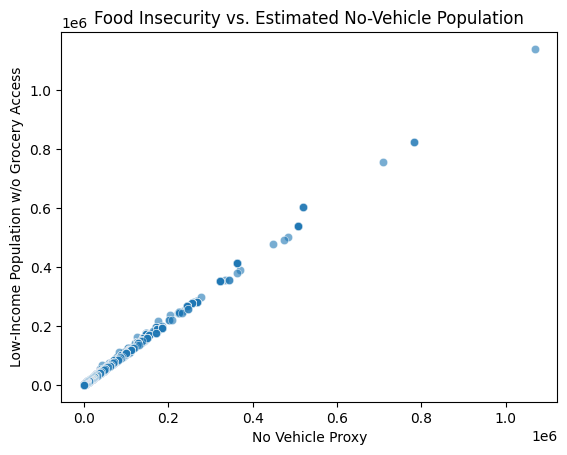

In [19]:
sns.scatterplot(
    data=plot_df,
    x='no_vehicle_proxy',
    y='low_access_low_income',
    alpha=0.6
)
plt.title("Food Insecurity vs. Estimated No-Vehicle Population")
plt.xlabel("No Vehicle Proxy")
plt.ylabel("Low-Income Population w/o Grocery Access")
plt.show()


###Inference:

1. There is a strong, direct relationship between lack of vehicle access and low-income food insecurity at the county level.

2. The visual trend shows very little scatter, meaning this pattern is consistent across different county types and population sizes.

3. This suggests that transportation access is a major structural contributor to food insecurity, and tackling it may directly reduce access-based hunger.



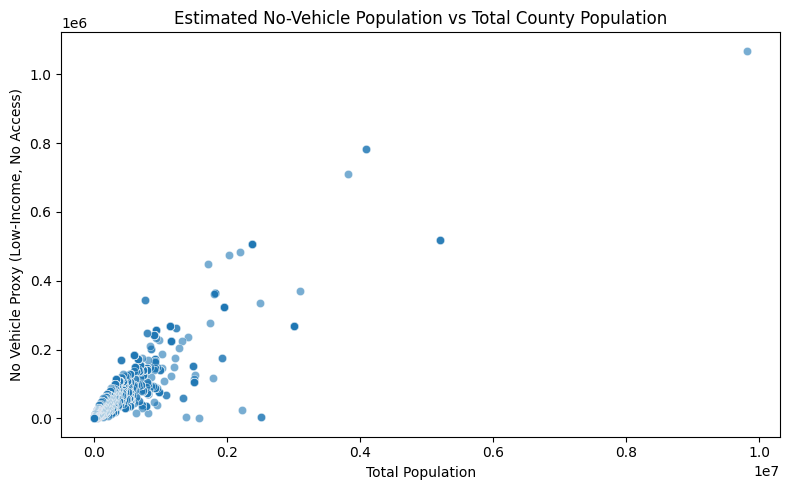

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=plot_df,
    x='total_population',
    y='no_vehicle_proxy',
    alpha=0.6
)
plt.title("Estimated No-Vehicle Population vs Total County Population")
plt.xlabel("Total Population")
plt.ylabel("No Vehicle Proxy (Low-Income, No Access)")
plt.tight_layout()
plt.show()


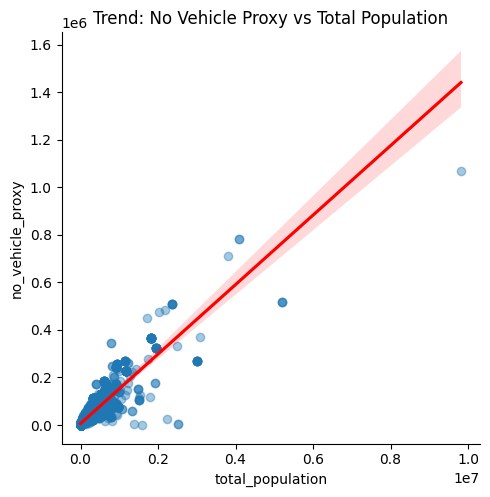

In [21]:
sns.lmplot(
    data=plot_df,
    x='total_population',
    y='no_vehicle_proxy',
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "red"}
)
plt.title("Trend: No Vehicle Proxy vs Total Population")
plt.show()


###Inference:

1. While larger populations generally face greater transportation-related food insecurity, the spread shows this isn’t always true.

2. Some counties with similar population sizes differ widely in their vulnerability, suggesting the influence of local infrastructure, transit options, and policy.

3. These findings support the use of targeted, structural indicators (like *no_vehicle_proxy*), rather than relying on population size alone when prioritizing intervention zones.

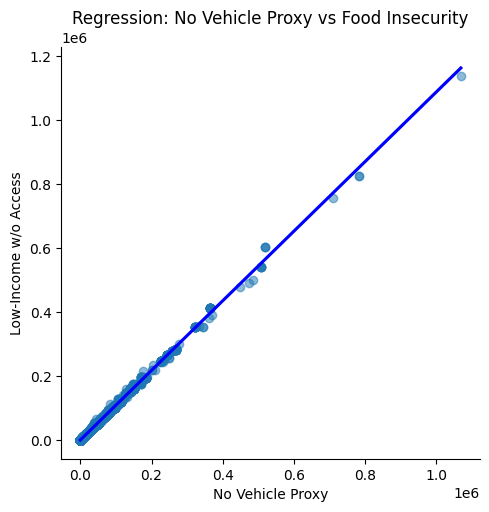

In [22]:
sns.lmplot(
    data=plot_df,
    x='no_vehicle_proxy',
    y='low_access_low_income',
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "blue"}
)
plt.title("Regression: No Vehicle Proxy vs Food Insecurity")
plt.xlabel("No Vehicle Proxy")
plt.ylabel("Low-Income w/o Access")
plt.show()


###Inference:

1. The regression fit shows a tight, reliable link between transportation inaccessibility and food insecurity across US counties.

2. Unlike population-driven visuals, this relationship is consistent and sharp, reinforcing the idea that compounded vulnerabilities are measurable and predictable.

3. This strengthens the argument for using transportation data as a key predictive tool for identifying food-insecure regions.

## Multivariate Analysis

---


*   Explore the relationship between three or more variables




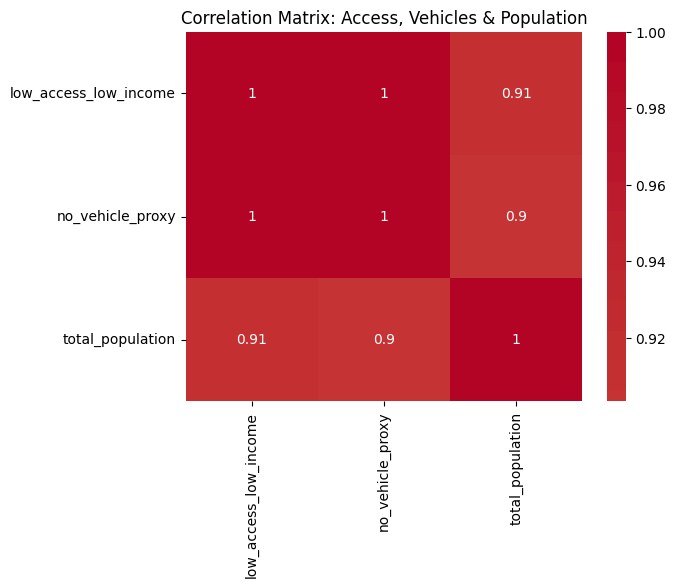

In [23]:
corr_df = plot_df[['low_access_low_income', 'no_vehicle_proxy', 'total_population']].copy()
corr_matrix = corr_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix: Access, Vehicles & Population")
plt.show()


###Inference:

1. There is an extremely strong correlation between food insecurity and transportation-based access issues, validating no_vehicle_proxy as a reliable indicator.

2. High correlations with population suggest that larger counties do experience more food insecurity, but this alone doesn’t explain all variance (as seen in earlier scatterplots).

3. This chart visually reinforces previous insights: structural access barriers, while population-linked, are best understood through targeted proxies rather than broad demographic measures.

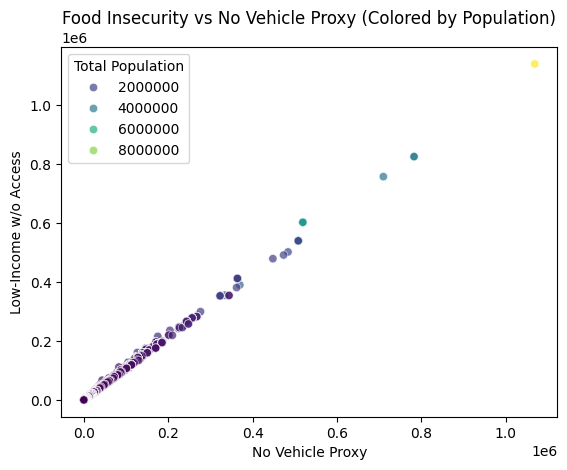

In [24]:
sns.scatterplot(
    data=plot_df,
    x='no_vehicle_proxy',
    y='low_access_low_income',
    hue='total_population',
    palette='viridis',
    alpha=0.7
)
plt.title("Food Insecurity vs No Vehicle Proxy (Colored by Population)")
plt.xlabel("No Vehicle Proxy")
plt.ylabel("Low-Income w/o Access")
plt.legend(title='Total Population', loc='upper left')
plt.show()


###Inference:

1. The consistent trend across color levels shows that the link between vehicle access and food insecurity exists across counties of all sizes.

2. While high-population counties naturally report higher affected numbers, smaller counties are still tightly aligned with the trend, underscoring the widespread nature of the issue.

3. This visualization confirms that the proxy can be scaled across geographies, making it a reliable tool for both urban and rural policy targeting.

# Conclusion

This analysis focused on exploring the relationship between food insecurity and transportation accessibility at the county level in the United States. By using the variable `no_vehicle_proxy` — a derived estimate of low-income individuals who lack both vehicle access and proximity to a supermarket — we aimed to highlight a compounded structural barrier to food access.

Key findings include:

- **Distributions of both food insecurity and transportation-related proxies are heavily right-skewed**, with the majority of counties experiencing low to moderate impact, and a few urban counties carrying disproportionate burdens.
- **A near-linear and consistent relationship exists between food insecurity and lack of vehicle access**, showing that structural transportation access is a strong predictor of food access challenges.
- While **total population is moderately correlated** with both variables, it does not fully explain the observed patterns — indicating that more targeted structural indicators (like our proxy) offer better insight.
- These trends hold true **across counties of varying sizes**, reinforcing that both urban and rural areas face transportation-related food insecurity in different forms.

Through multiple forms of analysis — univariate, bivariate, multivariate, and correlation-based — this study validates the use of the `no_vehicle_proxy` metric and provides a strong case for incorporating transportation accessibility into food insecurity policy interventions.
